## About
This notebook outlines a workflow for classifying samples via decision trees in cases where the data is perfectly separable[^1] and the attributes are subjective. It works through an example dataset, the "mushroom" (id=24)[^2] [^3] data from [OpenML](https://www.openml.org/).

The key consideration is "attributes are subjective". What one person thinks looks pink, another could think looks red. Does this mushroom smell faintly of almonds? I don't know... it kinda just smells like dirt! Having a decision tree that relies upon being able to confidently make these distinctions could be problematic.

The overall procedure is:
  - Use the unique data first:
    - Identify the categories within each attribute that all fall within one class (I'll call these "**pure classifiers**").[^4]
        - e.g. The samples in the category "foul" in the attribute "odor" all fall within the class "inedible".
    - Use these to try to classify your sample.
        - Any single one *should* yield a correct classification.[^4] [^5]
  - If that fails, you can try using the remaining data, which is the samples without any categories in any attribute that correspond to a single class (put another way, the sample has no pure classifiers):
    - For the failed pure classifiers:
      - If it failed because you couldn't tell for sure (e.g. pink vs red), then either:
        - Remove that entire attribute from your data.
        - Remove the rows for the categories you're unsure about.
    - You can either re-do the above process with the remaining data...
      - This subset may have newly pure categories
        - e.g. "broad" gill size is ambiguous in the full data, but after removing the pure classifiers' entries, its remaining subset is purely "edible".
    - ...or, create a decision tree from the remaining data.
      - If you *still* get stuck, you can remove the attribute that you're stuck on and rebuild the decision tree.

[^1]: One way to figure this out is if your decision tree on the whole dataset has all pure leaves.

[^2]: Reference paper: Schlimmer, JC. (1987). "[Concept acquisition through representational adjustment](https://escholarship.org/uc/item/48r6d4z0)". Technical Report Number 87-19.

[^3]: For some reason, the number of samples is larger in the OpenML data than in the reference paper.

[^4]: Importantly, this is predicated on you being confident that there aren't any unobserved instances that break these rules. e.g. All mushrooms with an "odor" of "anise" are edible in this data, but what if a newly discovered poisonous mushroom smells like anise?

[^5]: Contradictory results indicate an issue with your assessment, an issue with the data collector's assessment, imperfect separation of your data into the classes (e.g. all attributes in two samples are the same, but the classes are different), or [^4].

## Data pre-processing

First, get the data.

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml

In [2]:
data: pd.DataFrame
y: pd.Series
# mushroom v1
data, y = fetch_openml(data_id=24, return_X_y=True, parser="auto") # type: ignore

They encoded the categories as single letters. I guess to save space? In any case, here we're converting them to what they stand for:

In [3]:
converter = {
    "cap-shape" : dict(bell="b",conical="c",convex="x",flat="f",knobbed="k",sunken="s"),
    "cap-surface" : dict(fibrous="f",grooves="g",scaly="y",smooth="s"),
    "cap-color" : dict(brown="n",buff="b",cinnamon="c",gray="g",green="r",pink="p",purple="u",red="e",white="w",yellow="y"),
    "bruises%3F" : dict(bruises="t",no="f"),
    "odor" : dict(almond="a",anise="l",creosote="c",fishy="y",foul="f",musty="m",none="n",pungent="p",spicy="s"),
    "gill-attachment" : dict(attached="a",descending="d",free="f",notched="n"),
    "gill-spacing" : dict(close="c",crowded="w",distant="d"),
    "gill-size" : dict(broad="b",narrow="n"),
    "gill-color" : dict(black="k",brown="n",buff="b",chocolate="h",gray="g",green="r",orange="o",pink="p",purple="u",red="e",white="w",yellow="y"),
    "stalk-shape" : dict(enlarging="e",tapering="t"),
    "stalk-root" : dict(bulbous="b",club="c",cup="u",equal="e",rhizomorphs="z",rooted="r",missing="?"),
    "stalk-surface-above-ring" : dict(fibrous="f",scaly="y",silky="k",smooth="s"),
    "stalk-surface-below-ring" : dict(fibrous="f",scaly="y",silky="k",smooth="s"),
    "stalk-color-above-ring" : dict(brown="n",buff="b",cinnamon="c",gray="g",orange="o",pink="p",red="e",white="w",yellow="y"),
    "stalk-color-below-ring" : dict(brown="n",buff="b",cinnamon="c",gray="g",orange="o",pink="p",red="e",white="w",yellow="y"),
    "veil-type" : dict(partial="p",universal="u"),
    "veil-color" : dict(brown="n",orange="o",white="w",yellow="y"),
    "ring-number" : dict(none="n",one="o",two="t"),
    "ring-type" : dict(cobwebby="c",evanescent="e",flaring="f",large="l",none="n",pendant="p",sheathing="s",zone="z"),
    "spore-print-color" : dict(black="k",brown="n",buff="b",chocolate="h",green="r",orange="o",purple="u",white="w",yellow="y"),
    "population" : dict(abundant="a",clustered="c",numerous="n",scattered="s",several="v",solitary="y"),
    "habitat" : dict(grasses="g",leaves="l",meadows="m",paths="p",urban="u",waste="w",woods="d"),
}
# Flip k:v to v:k so we can convert "b" to "bell", etc.
for attr_k, attr_v in converter.items():
    converter[attr_k] = {v: k for k, v in attr_v.items()}

In [4]:
for attr in data.columns:
    data[attr] = data[attr].map(converter[attr])

Check for missing values:

In [5]:
missing_values = len(data.index) - data.count()
missing_values[missing_values > 0]

stalk-root    2480
dtype: int64

So I'll drop that column from the analysis.

In [6]:
data.drop("stalk-root", axis="columns", inplace=True)

Check for low-variance columns:

In [7]:
for c in data.columns:
    print("---- {} ----".format(c))
    print(data[c].value_counts())
    print("\n")

---- cap-shape ----
convex     3656
flat       3152
knobbed     828
bell        452
sunken       32
conical       4
Name: cap-shape, dtype: int64


---- cap-surface ----
scaly      3244
smooth     2556
fibrous    2320
grooves       4
Name: cap-surface, dtype: int64


---- cap-color ----
brown       2284
gray        1840
red         1500
yellow      1072
white       1040
buff         168
pink         144
cinnamon      44
green         16
purple        16
Name: cap-color, dtype: int64


---- bruises%3F ----
no         4748
bruises    3376
Name: bruises%3F, dtype: int64


---- odor ----
none        3528
foul        2160
spicy        576
fishy        576
almond       400
anise        400
pungent      256
creosote     192
musty         36
Name: odor, dtype: int64


---- gill-attachment ----
free        7914
attached     210
Name: gill-attachment, dtype: int64


---- gill-spacing ----
close      6812
crowded    1312
Name: gill-spacing, dtype: int64


---- gill-size ----
broad     5612
narrow

There's only one category for `veil-type`.

In [8]:
data.drop("veil-type", axis="columns", inplace=True)

## Use Pure Classifier Data
The following method, `find_pure_categories`, gives us a `DataFrame` of (category + attribute)'s, plus some statistics, that we can use to classify our sample. 

Any one of these will be sufficient. If you *do* find a contradiction, e.g. It smells like "anise" (should be edible), but it's gill color is "buff" (should be inedible), then you need to reevaluate, because there is a mistake somewhere: 
  - In your assessment of this sample.
  - In the representativeness of the data.
  - In the initial assessment of the data.

In [9]:
def find_pure_categories(data: pd.DataFrame, y):
    """
    Find pure categories and return them along with some statistics on them.

    "Pure categories" are the categories of an attribute that are entirely in one class.
    e.g. In the attribute "odor", mushrooms in the "foul" category are in the class "poisonous".
    data: Your data, with categorical attributes (columns where dtype == "category").
    y: The associated class labels.
    returns: A dataframe of the pure catgories + attribute + class, plus statistics:
      - count
      - x of y unique categories in attribute
      - x/y as %
      - % of data this category classifies
      - % of data this attribute's pure categories classify
    """
    full_data = data.copy()
    full_data["y"] = y
    cat_data = data.select_dtypes(include="category")

    dfs = []

    for col_name in cat_data.columns:
        # Group by categories in attribute (e.g. bruises t, bruises f), count the 'e' and 'p' for each category.
        q: pd.DataFrame = full_data.groupby(col_name)["y"].value_counts().rename("count").reset_index()
        # Get categories that are all poisonous or all edible.
        r: pd.DataFrame = q.groupby(col_name).filter(lambda df: any(df["count"] == 0))
        # Remove the 0 values.
        s: pd.DataFrame = r.groupby([col_name, "y"]).filter(lambda df: all(df["count"] != 0))
        # There's probably a better way to do this...
        s["Category"] = s[col_name].values.to_list()
        s["Attribute"] = col_name
        s["Identifier"] = s["Attribute"] + "_" + s["Category"]
        s.drop([col_name], axis="columns", inplace=True)
        s["Pure Categories in Attribute"] = str(len(s.index)) + " of " + str(len(q[col_name].cat.categories))
        s["Pct Pure Cat in Attr"] = (len(s.index) / len(q[col_name].cat.categories)) * 100
        s["Pct of Data Classified by Cat"] = (s["count"] / len(full_data.index)) * 100
        s["Pct of Data Classified by Attr's Pure Cats"] = (s["count"].sum() / len(full_data.index)) * 100
        dfs.append(s)

    pure_classifiers = pd.concat(dfs).reset_index(drop=True)
    return pure_classifiers

In [10]:
pure_classifiers = find_pure_categories(data, y)

## Use Not-Initially-Pure Classifier Data
If you couldn't classify your data with the above, or there were no unique (category + attribute)'s to begin with, then we can select the remaining data and work on that.

This is also the point where you'd evaluate whether to drop attributes that you've concluded you're not confident in using for this particular sample (or if you knew in advance (e.g. you're color blind), you could do it at the start).

In [24]:
def filter_out_pure_categories(data: pd.DataFrame, y):
    """
    Get the rows of data and their associated y's that have no pure categories.
    
    data: Your data, with categorical attributes (columns where dtype == "category").
    y: The associated class labels.
    returns: Filtered data.

    Example
    >>> test_data = pd.DataFrame(
    ...     {
    ...         "size": ["S", "S", "S", "M", "M", "M", "L", "L", "L", "XL", "XL"],
    ...         "color": ["green", "green", "black", "black", "blue", "blue", "green", "blue", "blue", "blue", "blue"],
    ...     },
    ...     dtype="category"
    ... )
    >>> test_y = pd.Series(
    ...     ["A", "A", "B", "B", "A", "A", "A", "A", "A", "A", "B"],
    ...     dtype="category",
    ...     name="class"
    ... )
    >>> test_data_filtered, test_y_filtered = filter_out_pure_categories(test_data, test_y)
    >>> test_data_filtered["class"] = test_y_filtered
    >>> test_data_filtered
       size color class
    4     M  blue     A
    5     M  blue     A
    9    XL  blue     A
    10   XL  blue     B
    """
    pure_classifiers = find_pure_categories(data, y)
    pure_cats_in_attrs = pure_classifiers.loc[:, ["Attribute", "Category"]].reset_index(drop=True)
    attrs_w_pure_cats = pure_classifiers["Attribute"].drop_duplicates().reset_index(drop=True)
    uncertain_data = data.copy()
    uncertain_data["y"] = y
    for attr in attrs_w_pure_cats:
        cats = pure_cats_in_attrs[pure_cats_in_attrs["Attribute"] == attr]["Category"]
        uncertain_data = uncertain_data[~uncertain_data[attr].isin(cats)]
    return uncertain_data.drop("y", axis="columns"), uncertain_data["y"]

In [12]:
uncertain_data, uncertain_y = filter_out_pure_categories(data, y)

The counts of each category, by attribute. Zero counts indicate the pure categories within each attribute.

In [13]:
for col in uncertain_data.columns:
    print("---- {} ----".format(col))
    print(uncertain_data[col].value_counts(), "\n")

---- cap-shape ----
convex     696
flat       649
knobbed     73
bell        57
conical      0
sunken       0
Name: cap-shape, dtype: int64 

---- cap-surface ----
fibrous    744
scaly      443
smooth     288
grooves      0
Name: cap-surface, dtype: int64 

---- cap-color ----
gray        496
brown       472
red         256
white       203
cinnamon     32
pink          8
yellow        8
buff          0
green         0
purple        0
Name: cap-color, dtype: int64 

---- bruises%3F ----
bruises    803
no         672
Name: bruises%3F, dtype: int64 

---- odor ----
none        1475
almond         0
creosote       0
foul           0
anise          0
musty          0
pungent        0
spicy          0
fishy          0
Name: odor, dtype: int64 

---- gill-attachment ----
free        1475
attached       0
Name: gill-attachment, dtype: int64 

---- gill-spacing ----
close      896
crowded    579
Name: gill-spacing, dtype: int64 

---- gill-size ----
broad     1344
narrow     131
Name: gill-size

We can iteratively do the above process:

In [14]:
newly_pure_classifiers = find_pure_categories(uncertain_data, uncertain_y)

In [15]:
uncertain_data_b, uncertain_y_b = filter_out_pure_categories(uncertain_data, uncertain_y)

Or we can make a decision tree:

### Create a Decision Tree
We'll use `sklearn`'s `DecisionTreeClassifier`. We have to one-hot encode our data because `sklearn` doesn't handle categorical data for decision trees for reasons.

In [16]:
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree

Making an optimal decision tree is an NP-complete problem. Here is a method to brute force a small tree, because fewer decisions is better I figure. You can also play around with the sample or class weights if you want to try to coerce a certain tree shape.

In [17]:
def brute_force_small_tree(data, y, max_features, n: int = 1_000):
    """
    data: your data, without the class column (y)
    y: your class column
    max_features: Passed to `sklearn.tree.DecisionTreeClassifier`. See its docs. Try a few values.
    n: number of iterations in brute force
    returns: (smallest_tree, smallest_tree_one_hot_encoder). Both are needed to plot with `tree.plot_tree`.
    """
    smallest_node_count = 1_000_000
    smallest_tree = None
    smallest_tree_ohe = None

    for _ in range(n):
        tree_pipe = make_pipeline(
            OneHotEncoder(handle_unknown="ignore"), 
            tree.DecisionTreeClassifier(max_features=max_features)
        )
        tree_pipe.fit(data, y)

        tree_ohe: OneHotEncoder = tree_pipe[0]
        tree_tree: tree.DecisionTreeClassifier = tree_pipe[1]
        if tree_tree.tree_.node_count < smallest_node_count:
            smallest_tree = tree_tree
            smallest_tree_ohe = tree_ohe
            smallest_node_count = tree_tree.tree_.node_count
            print("smallest tree: ", smallest_node_count)
    return smallest_tree, smallest_tree_ohe
        

In [18]:
smallest_tree, smallest_tree_ohe = brute_force_small_tree(uncertain_data, uncertain_y, 0.8)

smallest tree:  9
smallest tree:  7


In [19]:
def plot_decision_tree(fitted_tree: tree.DecisionTreeClassifier, fitted_one_hot_encoder: OneHotEncoder):
    fig: plt.Figure
    ax: plt.Axes
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10) # Resize if needed.

    tree.plot_tree(fitted_tree, 
        feature_names=fitted_one_hot_encoder.get_feature_names_out(),
        class_names=fitted_tree.classes_
        )

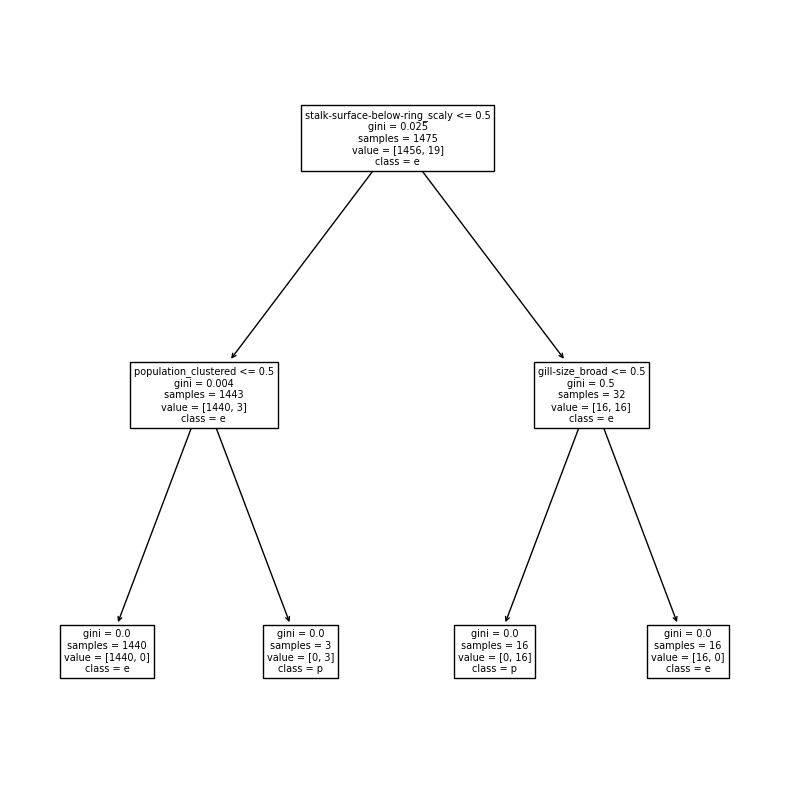

In [20]:
plot_decision_tree(smallest_tree, smallest_tree_ohe)

So the way to read the decision tree is:
  - The left path means True, right means False
  - `samples = N` refers to how many samples this particular node is dealing with, as determined by all of its parent nodes
  - `value = [a, b]` refers to the current classification counts of your `samples`, given all of the parent nodes, where I believe it just goes in numerical / alphabetical order.
      - For example, the root node has had no splitting done, so its `value`s are just the counts of each class in your data set.
      - In a root node's child, the `value`s are the counts of each class in the subset of your data. So above, at `population_several <= 0.5` is false (right child), there were 16 samples where this was the case, and of those 16, all 16 or poisonous.
  - `class = x` refers to whichever value in `value` is largest, i.e. majority rules. If we had 86 for 'p' and only 85 for 'e', we'd call everything in this node 'p'.
  - (an example) `population_several <= 0.5` refers to the decision that the node will use to split into two children. It is not a consideration for the `value` or `class` values in its own node.

## Test

In [25]:
import doctest
doctest.testmod()

TestResults(failed=0, attempted=5)

In case you want to interact with an example for `filter_out_pure_categories`...

Here I've put in two cases:
  1. size = "M" is in both class A and B, but after removing the (size = "M" and color = "black") row due to "black" being purely B, we are left with "M"'s that are purely A.
  2. size = "XL" demonstrates contradictory samples. You can't get perfect classification with your data.

In [22]:
test_data = pd.DataFrame(
    {
        "size": ["S", "S", "S", "M", "M", "M", "L", "L", "L", "XL", "XL"],
        "color": ["green", "green", "black", "black", "blue", "blue", "green", "blue", "blue", "blue", "blue"],
    },
    dtype="category"
)
test_y = pd.Series(
    ["A", "A", "B", "B", "A", "A", "A", "A", "A", "A", "B"],
    dtype="category",
    name="class"
)
full_test_data = test_data.copy()
full_test_data["class"] = test_y

test_data_filtered, test_y_filtered = filter_out_pure_categories(test_data, test_y)
test_data_filtered["class"] = test_y_filtered
test_data_filtered